# Imports & Pre-requisites

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import re
from collections import Counter
import contractions
from pattern.en import suggest
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk import ngrams
import html
from string import punctuation
import csv
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from glove import Corpus, Glove
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
import zipfile
from sklearn.preprocessing import StandardScaler

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
HEADERS = ["polarity", "id","date","query","user","content", "text_content", "onegram", "bigrams"]
TRAIN_FILE_LOC = "data/training.1600000.processed.noemoticon.csv"
TEST_FILE_LOC = "data/testdata.manual.2009.06.14.csv"
CLEAN_TRAIN_FILE_LOC = "data/clean.training.1600000.processed.noemoticon.p"
CLEAN_TEST_FILE_LOC = "data/clean.testdata.manual.2009.06.14.p"
#POS_TAGGED_TRAIN_FILE_LOC = "data/pos-tagged.training.1600000.processed.noemoticon.csv"
#POS_TAGGED_TEST_FILE_LOC = "data/pos-tagged.testdata.manual.2009.06.14.csv"
FINAL_DATAFRAME_FILE_LOC = "data/y-dataframe.csv"
X_INPUT_FILE_LOC = "data/x-inputs.p"
ZIPPED_X_INPUT_FILE_LOC = "data/x-zipped-inputs.p"
GLOVE_MODEL='data/glove.model'
CORPUS_MODEL='data/corpus.model'
GLOVE_VEC_VALUES='data/glove-vec-values.p'
GLOVE_840B_300D_PATH='data/glove.840B.300d.txt'
SEED=42

sns.set(color_codes=True)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
%%bash
wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip --directory-prefix=./data

In [ ]:
zip = zipfile.ZipFile('data/trainingandtestdata.zip')
zip.extractall(path='./data')

In [51]:
training_data = pd.read_csv(TRAIN_FILE_LOC, header=None, encoding='latin-1',names=HEADERS)
test_data = pd.read_csv(TEST_FILE_LOC, header=None, encoding='latin-1',names=HEADERS)

# Initial Data Analysis

In [52]:
tokenizer = TweetTokenizer()

def convert_tweet_array_to_vector_count(data, word_vector_already=False) :
    word_vector = []
    if(word_vector_already == False) :
        print("tokenizing dataframe")
        word_vector = data["content"].apply(tokenizer.tokenize)
        print("done tokenizing")
    else :
        word_vector = data['content']
    
    print("creating word vector from tokens")
    word_vector = [item for sublist in word_vector for item in sublist]
    word_counts = Counter(word_vector)
    df = pd.DataFrame.from_dict(word_counts, orient='index')
    df = df.sort_values(df.columns[0],ascending = False)
    print("done creating vector")
    return df

def describe_data_set(data, parse_tokenizer = False) :
    
    print("data head:")
    display(data.head())
    
    print("distribution of polarity:")
    fig = sns.distplot(data["polarity"], kde=False, rug=True)
    fig.xaxis.set_major_locator(ticker.MultipleLocator(2))
    plt.show()
    
    df = convert_tweet_array_to_vector_count(data, parse_tokenizer)
    a4_dims = (15, 12)

    top_50 = df.head(100)
    bottom_50 = df.tail(100)
    
    print("top words visualisation:")
    fig, ax = plt.subplots(figsize=a4_dims)
    
    fig = sns.barplot(x=top_50.index.values.tolist(),y=top_50.iloc[:, 0], ax=ax)
    fig.set_xticklabels(top_50.index.values.tolist(), rotation=90)
    
    plt.show()
    
    print("bottom words visualisation:")
    fig2, ax = plt.subplots(figsize=a4_dims)
    fig2 = sns.barplot(x=bottom_50.index.values.tolist(),y=bottom_50.iloc[:, 0], ax=ax)
    fig2.set_xticklabels(bottom_50.index.values.tolist(), rotation=90)
    
    plt.show()
    
    print("any rows with null values:")
    data[data.isnull().any(axis=1)].head()
    
    print("word cloud for positive words")
    tweets = data[data['polarity'] == 4]
    tweet_string = ''
    display(tweets.head())

    for row in tweets['content'] :
        if(parse_tokenizer) :
            for word in row :
                tweet_string += word + ' '
        else :
            tweet_string += row + ' '

    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweet_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    print("word cloud for negative words")
    tweets = data[data['polarity'] == 0]
    display(tweets.head())
    tweet_string = ''

    for row in tweets['content'] :
        if(parse_tokenizer) :
            for word in row :
                tweet_string += word + ' '
        else :
            tweet_string += row + ' '

    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweet_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    


data head:


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.",NaN,NaN,NaN
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.,NaN,NaN,NaN
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!",NaN,NaN,NaN
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :),NaN,NaN,NaN
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :),NaN,NaN,NaN


distribution of polarity:


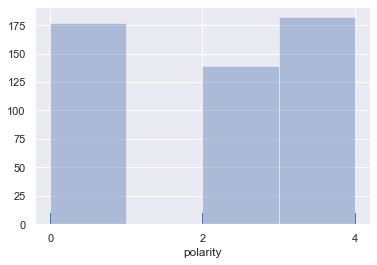

tokenizing dataframe
done tokenizing
creating word vector from tokens
done creating vector
top words visualisation:


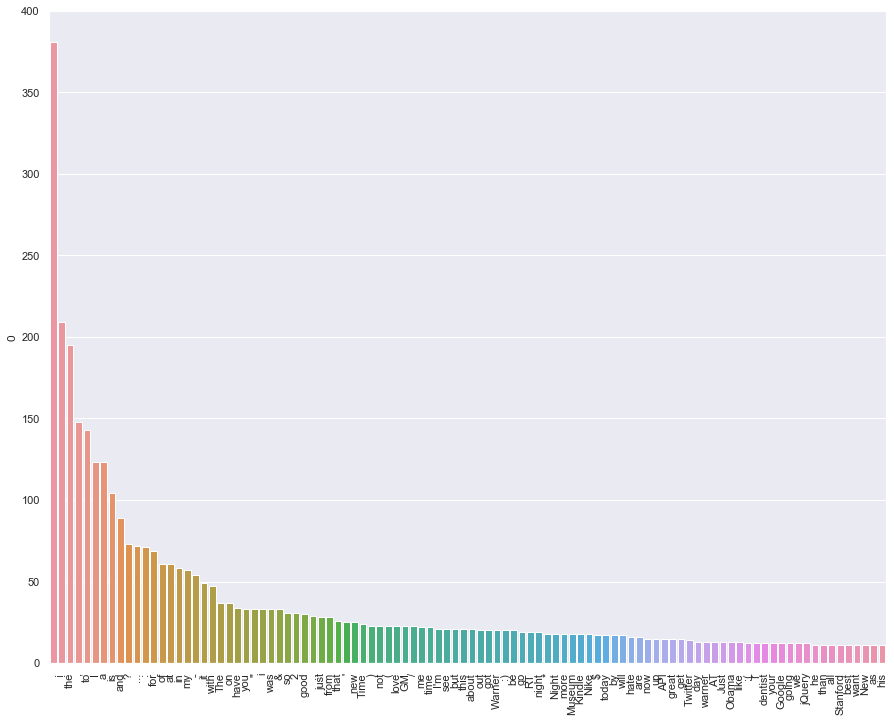

bottom words visualisation:


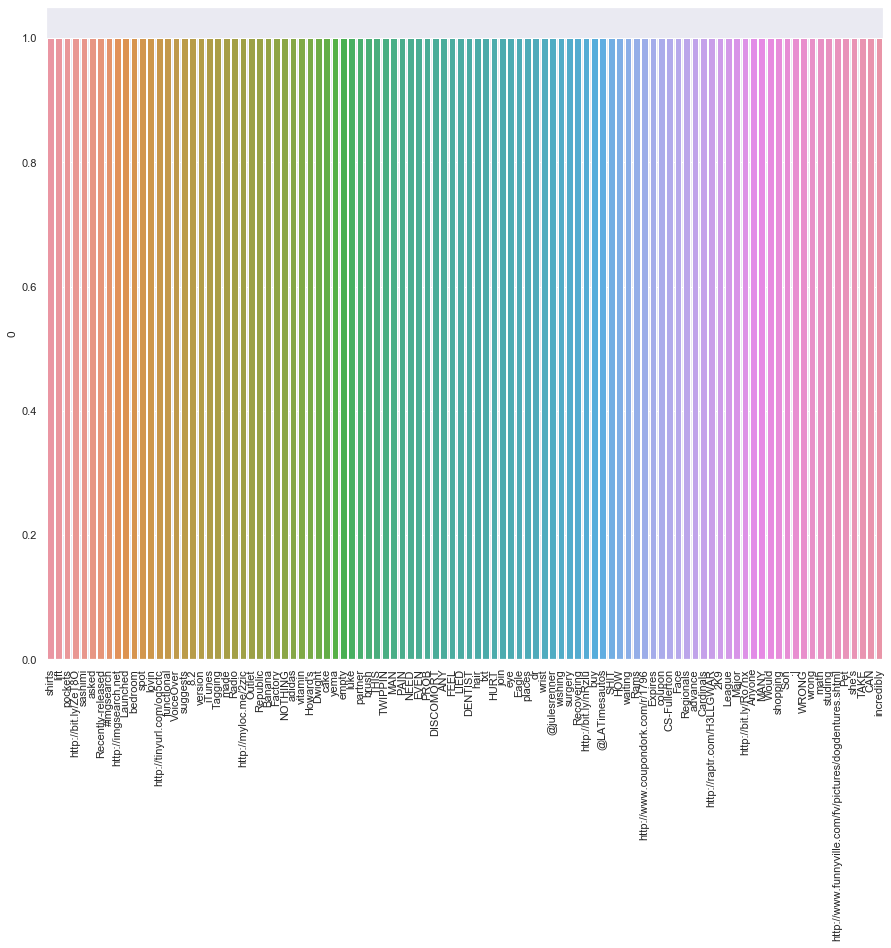

any rows with null values:
word cloud for positive words


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.",NaN,NaN,NaN
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.,NaN,NaN,NaN
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!",NaN,NaN,NaN
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :),NaN,NaN,NaN
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :),NaN,NaN,NaN


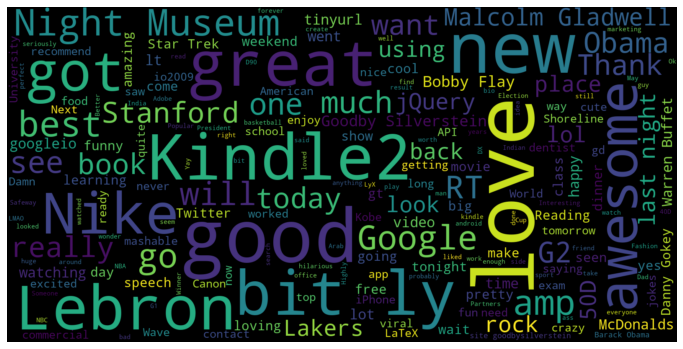

word cloud for negative words


,polarity,id,date,query,user,content,text_content,onegram,bigrams
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non loan given asses.,NaN,NaN,NaN
11,0,14,Mon May 11 03:32:48 UTC 2009,obama,kylesellers,"@Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil. It's a charade and a slogan, but they want to destroy conservatism",NaN,NaN,NaN
14,0,17,Mon May 11 05:06:22 UTC 2009,nike,vincentx24x,"dear nike, stop with the flywire. that shit is a waste of science. and ugly. love, @vincentx24x",NaN,NaN,NaN
16,0,19,Mon May 11 05:20:28 UTC 2009,lebron,luv8242,I was talking to this guy last night and he was telling me that he is a die hard Spurs fan. He also told me that he hates LeBron James.,NaN,NaN,NaN
18,0,21,Mon May 11 05:21:37 UTC 2009,lebron,ursecretdezire,"@ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end.",NaN,NaN,NaN


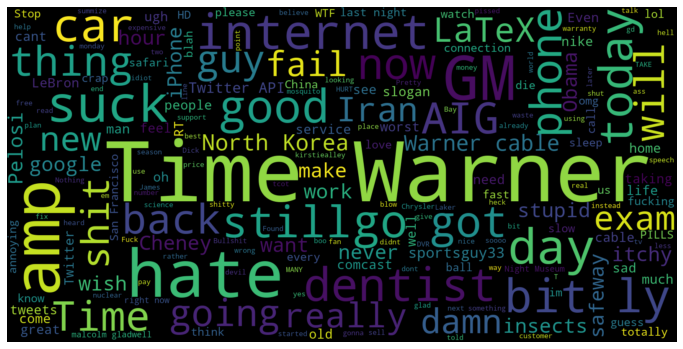

In [53]:
describe_data_set(test_data)

data head:


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",NaN,NaN,NaN
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,NaN,NaN,NaN
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,NaN,NaN,NaN
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,NaN,NaN,NaN
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",NaN,NaN,NaN


distribution of polarity:


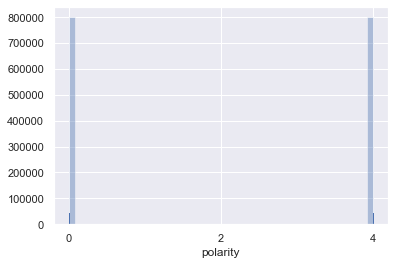

tokenizing dataframe
done tokenizing
creating word vector from tokens
done creating vector
top words visualisation:


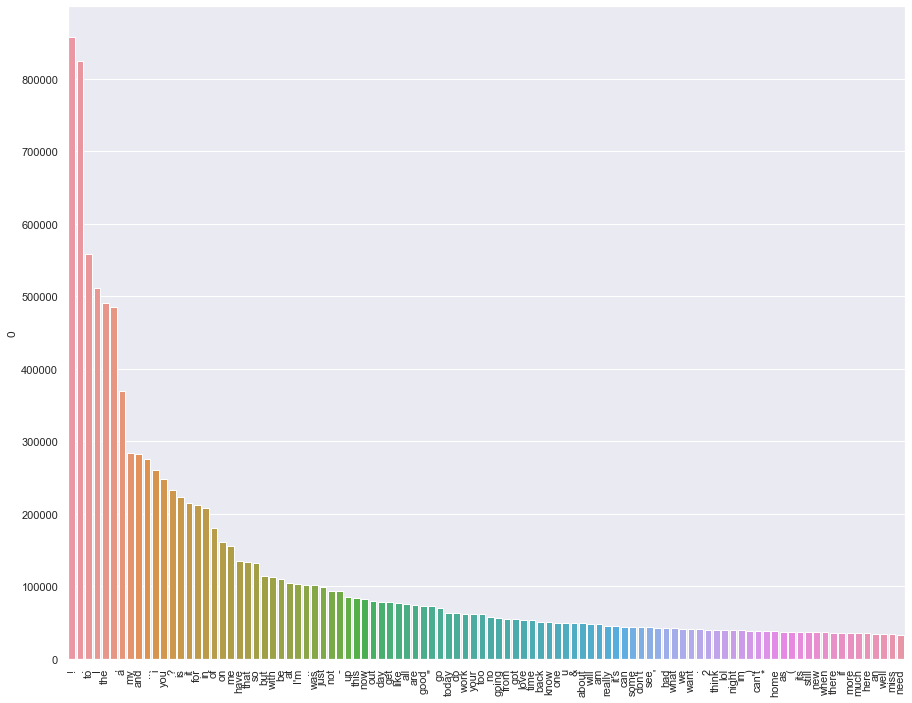

bottom words visualisation:


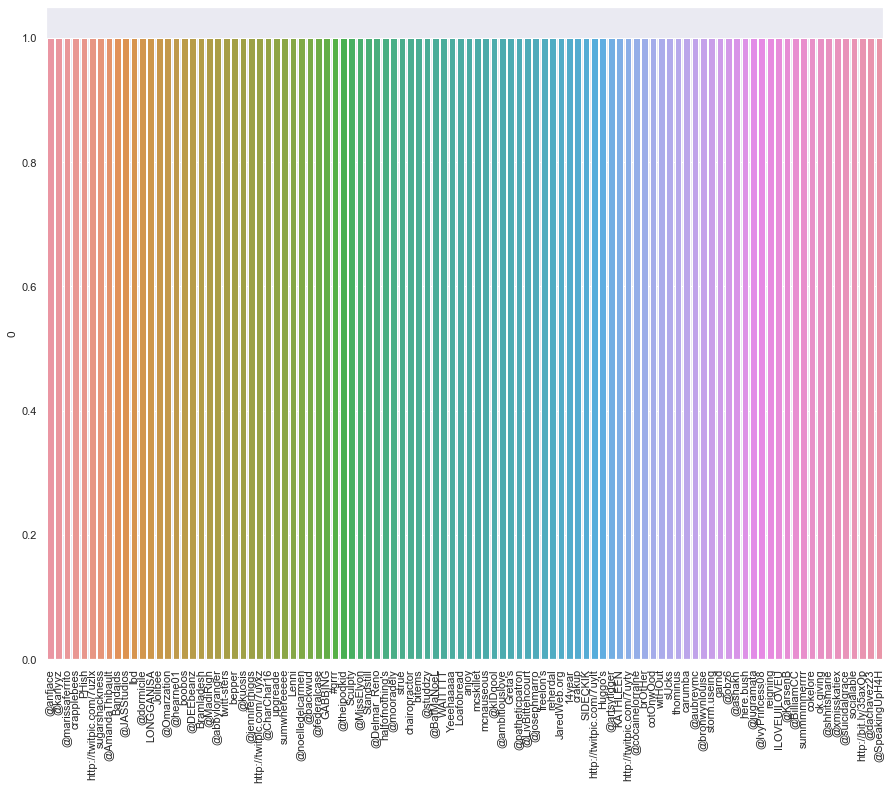

any rows with null values:
word cloud for positive words


,polarity,id,date,query,user,content,text_content,onegram,bigrams
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,NaN,NaN,NaN
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,NaN,NaN,NaN
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",NaN,NaN,NaN
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",NaN,NaN,NaN
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,NaN,NaN,NaN


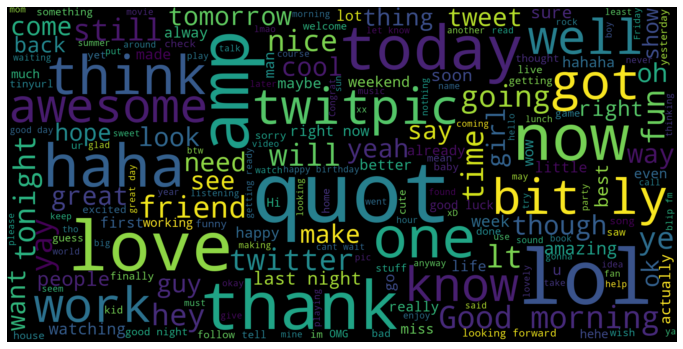

word cloud for negative words


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",NaN,NaN,NaN
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,NaN,NaN,NaN
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,NaN,NaN,NaN
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,NaN,NaN,NaN
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",NaN,NaN,NaN


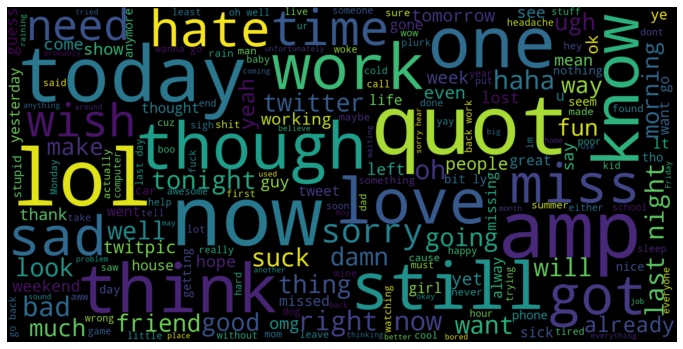

In [54]:
describe_data_set(training_data)

# Data Pre-processing

In [55]:
def expand_contractions(text):
    return contractions.fix(text)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_extra_letters(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1", text)

def fix_misspelled_vectors(vector) :
    for i in range(len(vector)) :
        vector[i] = spell(vector[i])
    
    return vector

stopword = stopwords.words('english')

def remove_stopwords(vector) :
    return [word for word in vector if word not in stopword]

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_words(vector) :
    return [wordnet_lemmatizer.lemmatize(word) for word in vector]

def remove_digits(text) :
    return ''.join(c for c in text if not c.isdigit())

def remove_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)
            
def remove_abbreviations(user_string, abbreviation_list):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        
        # Removing Special Characters.
        _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
        for row in abbreviation_list:
            # Check if selected word matches short forms[LHS] in text file.
            if _str.upper() == row[0]:
                # If match found replace it with its Abbreviation in text file.
                user_string[j] = row[1].lower()
        j = j + 1
    # Replacing commas with spaces for final output.
    return ' '.join(user_string)

def remove_urls(url_string) :
    return re.sub(r"http\S+", "", re.sub(r'www.[^ ]+',"", url_string))

def remove_usernames(tweet_string) :
    return re.sub(r'@[A-Za-z0-9]+','',tweet_string)



In [56]:
def copy_string(string):
    return (string + '.')[:-1]

def clean_data_output(data, start_sentence, previous_value = False, new_value = False, verbose_output = False, parse_vector = True) :
    print(start_sentence)
    if(previous_value != False) :
        print(previous_value)
    if(new_value != False) :
        print(new_value)
    
    if(verbose_output) :
        data_vector = convert_tweet_array_to_vector_count(data, parse_vector == False)
        print("number of unique items in vector",  len(data_vector.index))
    
    print('-------------\n')

def clean_data(data, verbose_output = False) :
    clean_data_output(data, "starting clean", False, False, verbose_output)  
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].str.lower()
    after_datapoint = data['content'][0]
    clean_data_output(data, "transform to lowercase", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][12])
    data['content'] = data['content'].apply(html.unescape)
    after_datapoint = data['content'][12]
    clean_data_output(data, "html decode characters", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][5])
    data['content'] = data['content'].apply(expand_contractions)
    after_datapoint = data['content'][5]
    clean_data_output(data, "expand contractions", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][122])
    data['content'] = data['content'].apply(remove_urls)
    after_datapoint = data['content'][122]
    clean_data_output(data, "remove urls", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].apply(remove_usernames)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove usernames", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].apply(remove_punctuation)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove punctuation", before_datapoint, after_datapoint, verbose_output) 
    
    # File path which consists of Abbreviations.
    fileName = "abbreviations.txt"
    # File Access mode [Read Mode]
    accessMode = "r"
    with open(fileName, accessMode) as myCSVfile:
        # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
        dataFromFile = csv.reader(myCSVfile, delimiter="=")

        before_datapoint = copy_string(data['content'][20])
        data['content'] = data['content'].apply(lambda x: remove_abbreviations(x,dataFromFile))
        after_datapoint = data['content'][20]
        clean_data_output(data, "remove abbreviations", before_datapoint, after_datapoint, verbose_output) 

        myCSVfile.close()
    
    before_datapoint = copy_string(data['content'][122])
    data['content'] = data['content'].apply(remove_digits)
    after_datapoint = data['content'][122]
    clean_data_output(data, "remove digits", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].apply(remove_extra_letters)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove extra letters", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][12])
    data['content'] = data['content'].apply(tokenizer.tokenize)
    data['content'] = data['content'].apply(lemmatize_words)
    after_datapoint = data['content'][12]
    clean_data_output(data, "lemmatize words", before_datapoint, after_datapoint, verbose_output, False) 
    
    before_datapoint = data['content'][0].copy()
    data['content'] = data['content'].apply(remove_stopwords)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove stop words", before_datapoint, after_datapoint, verbose_output, False) 
    
    print('clean done')
    return data


In [58]:
test_data = clean_data(test_data, True)


starting clean
tokenizing dataframe
done tokenizing
creating word vector from tokens
done creating vector
number of unique items in vector 2732
-------------

transform to lowercase
@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.
@stellargirl i loooooooovvvvvveee my kindle2. not that the dx is cool, but the 2 is fantastic in its own right.
tokenizing dataframe
done tokenizing
creating word vector from tokens
done creating vector
number of unique items in vector 2349
-------------

html decode characters
house correspondents dinner was last night whoopi, barbara &amp; sherri went, obama got a standing ovation
house correspondents dinner was last night whoopi, barbara & sherri went, obama got a standing ovation
tokenizing dataframe
done tokenizing
creating word vector from tokens
done creating vector
number of unique items in vector 2349
-------------

expand contractions
@richardebaker no. it is too big. i'm quite happy wit

In [62]:
training_data = clean_data(training_data)


starting clean
-------------

transform to lowercase
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
@switchfoot http://twitpic.com/2y1zl - awww, that's a bummer.  you shoulda got david carr of third day to do it. ;d
-------------

html decode characters
@caregiving i couldn't bear to watch it.  and i thought the ua loss was embarrassing . . . . .
@caregiving i couldn't bear to watch it.  and i thought the ua loss was embarrassing . . . . .
-------------

expand contractions
@kwesidei not the whole crew 
@kwesidei not the whole crew 
-------------

remove urls
i know my life has been flipped upside down when i just thought in my head that some ramen sounds good. 
i know my life has been flipped upside down when i just thought in my head that some ramen sounds good. 
-------------

remove usernames
@switchfoot  - awww, that is a bummer.  you shoulda got david carr of third day to do it. ;d
  - awww, that is a bummer.  y

In [63]:
test_data['text_content'] = test_data['content'].apply(lambda x: ' '.join(x))
training_data['text_content'] = training_data['content'].apply(lambda x: ' '.join(x))

In [64]:
test_data.to_pickle(CLEAN_TEST_FILE_LOC)
training_data.to_pickle(CLEAN_TRAIN_FILE_LOC)

In [65]:
training_data = pd.read_pickle(CLEAN_TRAIN_FILE_LOC)
test_data = pd.read_pickle(CLEAN_TEST_FILE_LOC)
display(test_data.head())
display(training_data.head())

,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"[love, kindle, dx, cool, fantastic, right]",love kindle dx cool fantastic right,NaN,NaN
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,"[reading, kindle, love, lee, child, good, read]",reading kindle love lee child good read,NaN,NaN
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"[ok, first, assesment, kindle, fucking, rock]",ok first assesment kindle fucking rock,NaN,NaN
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,"[love, kindle, I, mine, month, never, looked, back, new, big, one, huge, need, remorse]",love kindle I mine month never looked back new big one huge need remorse,NaN,NaN
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,"[fair, enough, kindle, think, perfect]",fair enough kindle think perfect,NaN,NaN


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[aw, bummer, shoulda, got, david, carr, third, day]",aw bummer shoulda got david carr third day,NaN,NaN
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry, result, school, today, also, blah]",upset update facebook texting might cry result school today also blah,NaN,NaN
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[dived, many, time, ball, managed, save, rest, go, bound]",dived many time ball managed save rest go bound,NaN,NaN
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire,NaN,NaN
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[behaving, I, mad, see]",behaving I mad see,NaN,NaN


describe clean test data:
data head:


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,4,18,Mon May 11 05:20:15 UTC 2009,lebron,cameronwylie,"[lebron, best, athlete, generation, time, basketball, related, want, get, intersport, debate]",lebron best athlete generation time basketball related want get intersport debate,"['lebron', 'best', 'athlete', 'generation', 'time', 'basketball', 'related', 'want', 'get', 'intersport', 'debate']","['lebron', 'best', 'athlete', 'generation', 'time', 'basketball', 'related', 'want', 'get', 'intersport', 'debate']"
1,2,175,Wed May 20 02:38:45 UTC 2009,nike,cadburysgirl,"[next, time, I, call, nike]",next time I call nike,"['next', 'time', 'I', 'call', 'nike']","['next', 'time', 'I', 'call', 'nike']"
2,4,26,Mon May 11 06:02:24 UTC 2009,iphone app,CocoSavanna,"[downloading, apps, iphone, much, fun, literally, app, anything]",downloading apps iphone much fun literally app anything,"['downloading', 'apps', 'iphone', 'much', 'fun', 'literally', 'app', 'anything']","['downloading', 'apps', 'iphone', 'much', 'fun', 'literally', 'app', 'anything']"
3,2,2100,Sun May 17 17:30:03 UTC 2009,san francisco,bKnapp,"[breaker, san, francisco, ca]",breaker san francisco ca,"['breaker', 'san', 'francisco', 'ca']","['breaker', 'san', 'francisco', 'ca']"
4,2,2122,Mon May 18 03:12:23 UTC 2009,"""twitter api""",Hot_Tweets,"[testing, twitter, api, remote, update]",testing twitter api remote update,"['testing', 'twitter', 'api', 'remote', 'update']","['testing', 'twitter', 'api', 'remote', 'update']"


distribution of polarity:


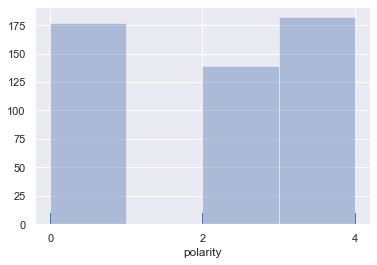

creating word vector from tokens
done creating vector
top words visualisation:


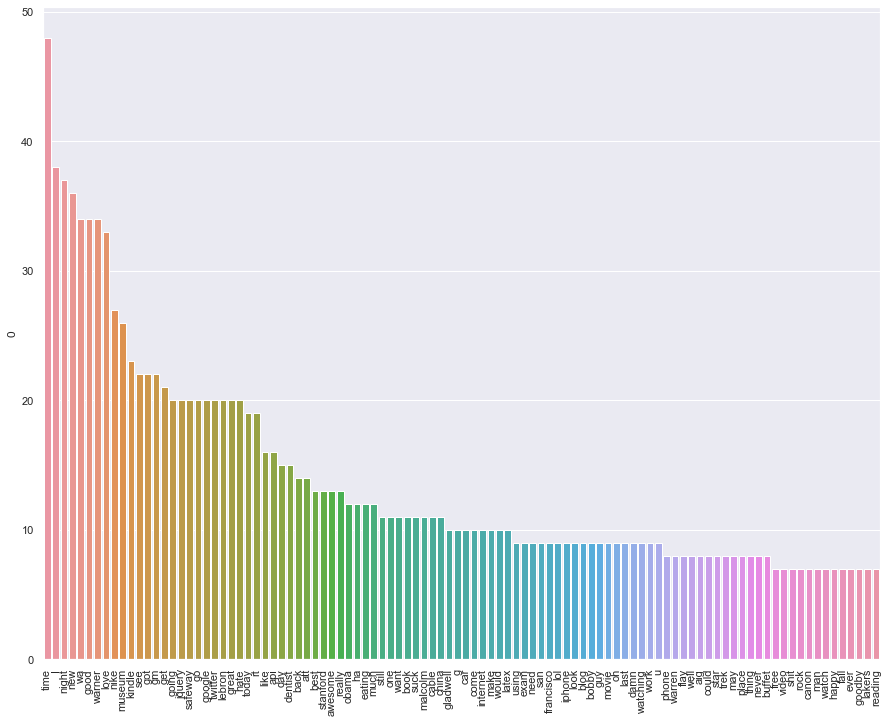

bottom words visualisation:


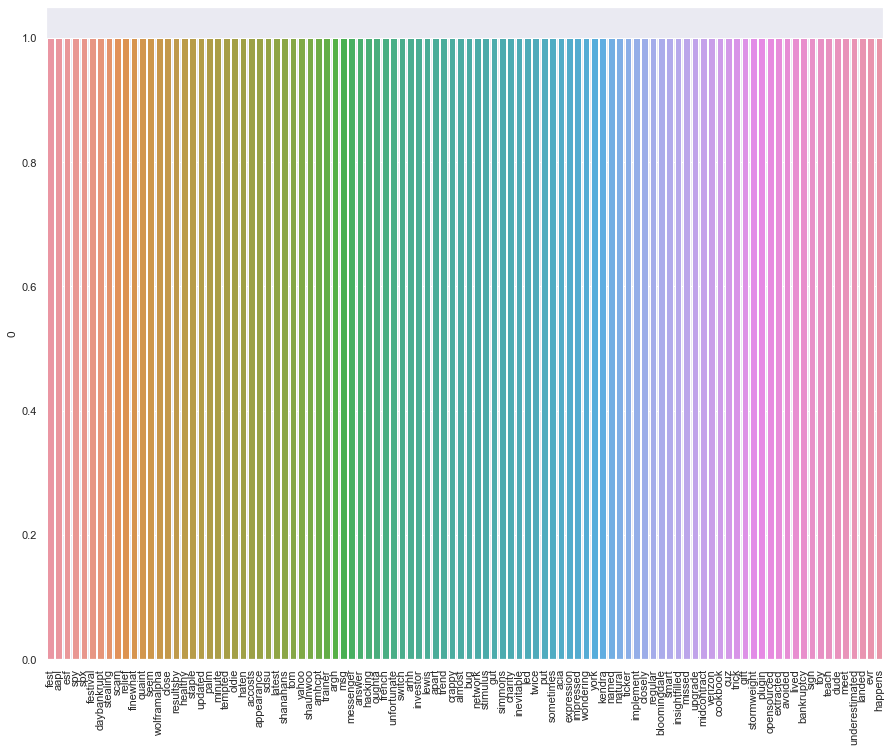

any rows with null values:
word cloud for positive words


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,4,18,Mon May 11 05:20:15 UTC 2009,lebron,cameronwylie,"[lebron, best, athlete, generation, time, basketball, related, want, get, intersport, debate]",lebron best athlete generation time basketball related want get intersport debate,"['lebron', 'best', 'athlete', 'generation', 'time', 'basketball', 'related', 'want', 'get', 'intersport', 'debate']","['lebron', 'best', 'athlete', 'generation', 'time', 'basketball', 'related', 'want', 'get', 'intersport', 'debate']"
2,4,26,Mon May 11 06:02:24 UTC 2009,iphone app,CocoSavanna,"[downloading, apps, iphone, much, fun, literally, app, anything]",downloading apps iphone much fun literally app anything,"['downloading', 'apps', 'iphone', 'much', 'fun', 'literally', 'app', 'anything']","['downloading', 'apps', 'iphone', 'much', 'fun', 'literally', 'app', 'anything']"
9,4,2085,Sat May 16 23:48:10 UTC 2009,stanford,PassionModel,"[stanford, charity, fashion, show, top, draw]",stanford charity fashion show top draw,"['stanford', 'charity', 'fashion', 'show', 'top', 'draw']","['stanford', 'charity', 'fashion', 'show', 'top', 'draw']"
15,4,395,Tue Jun 02 02:55:25 UTC 2009,"""night at the museum""",droherty,"[watching, night, museum, getting, really, good]",watching night museum getting really good,"['watching', 'night', 'museum', 'getting', 'really', 'good']","['watching', 'night', 'museum', 'getting', 'really', 'good']"
17,4,2140,Wed May 20 02:38:17 UTC 2009,nike,Chet_Lemon,"[new, nike, muppet, commercial, pretty, cute, live, together]",new nike muppet commercial pretty cute live together,"['new', 'nike', 'muppet', 'commercial', 'pretty', 'cute', 'live', 'together']","['new', 'nike', 'muppet', 'commercial', 'pretty', 'cute', 'live', 'together']"


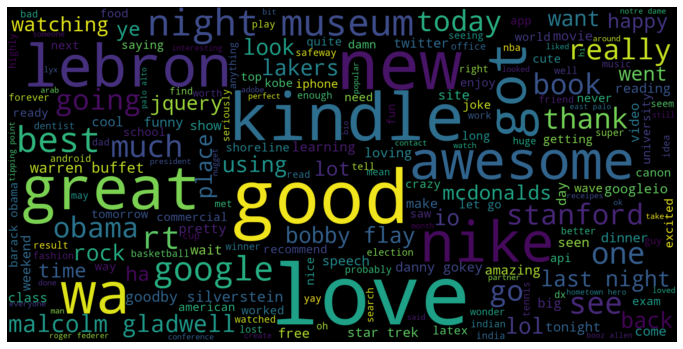

word cloud for negative words


,polarity,id,date,query,user,content,text_content,onegram,bigrams
7,0,2010,Thu May 14 02:58:11 UTC 2009,"""booz allen""",Moc5085,"[go, booz, allen, hamilton, hr, meeting, get, go, home]",go booz allen hamilton hr meeting get go home,"['go', 'booz', 'allen', 'hamilton', 'hr', 'meeting', 'get', 'go', 'home']","['go', 'booz', 'allen', 'hamilton', 'hr', 'meeting', 'get', 'go', 'home']"
10,0,156,Mon May 18 03:13:03 UTC 2009,yahoo,CarolineVilas,"[yahoo, answer, butt, sometimes]",yahoo answer butt sometimes,"['yahoo', 'answer', 'butt', 'sometimes']","['yahoo', 'answer', 'butt', 'sometimes']"
11,0,2397,Tue Jun 02 03:27:52 UTC 2009,gm,ram_zone,"[gm, file, bankruptcy, good, sign]",gm file bankruptcy good sign,"['gm', 'file', 'bankruptcy', 'good', 'sign']","['gm', 'file', 'bankruptcy', 'good', 'sign']"
13,0,2545,Mon Jun 08 00:12:16 UTC 2009,kindle2,nyctimes,"[still, love, kindle, reading, new, york, time, doe, feel, natural, miss, bloomingdale, ad]",still love kindle reading new york time doe feel natural miss bloomingdale ad,"['still', 'love', 'kindle', 'reading', 'new', 'york', 'time', 'doe', 'feel', 'natural', 'miss', 'bloomingdale', 'ad']","['still', 'love', 'kindle', 'reading', 'new', 'york', 'time', 'doe', 'feel', 'natural', 'miss', 'bloomingdale', 'ad']"
23,0,228,Mon May 25 17:46:24 UTC 2009,twitter api,jos897,"[srsly, hate, stupid, twitter, api, timeout, thing, annoying]",srsly hate stupid twitter api timeout thing annoying,"['srsly', 'hate', 'stupid', 'twitter', 'api', 'timeout', 'thing', 'annoying']","['srsly', 'hate', 'stupid', 'twitter', 'api', 'timeout', 'thing', 'annoying']"


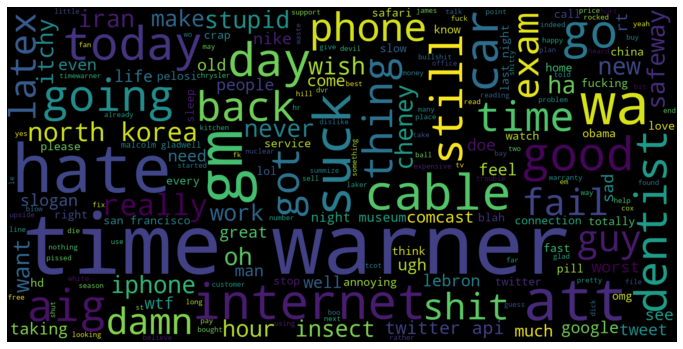

In [140]:
print("describe clean test data:")
describe_data_set(test_data, True)

describe clean taining data:
data head:


,polarity,id,date,query,user,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[aw, bummer, shoulda, got, david, carr, third,..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[dived, many, time, ball, managed, save, rest,..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[behaving, I, mad, see]"


distribution of polarity:


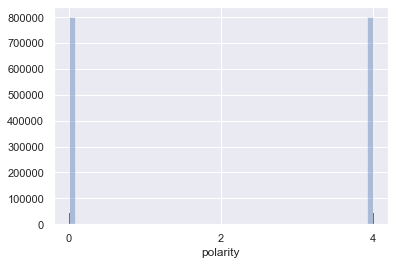

creating word vector from tokens
done creating vector
top words visualisation:


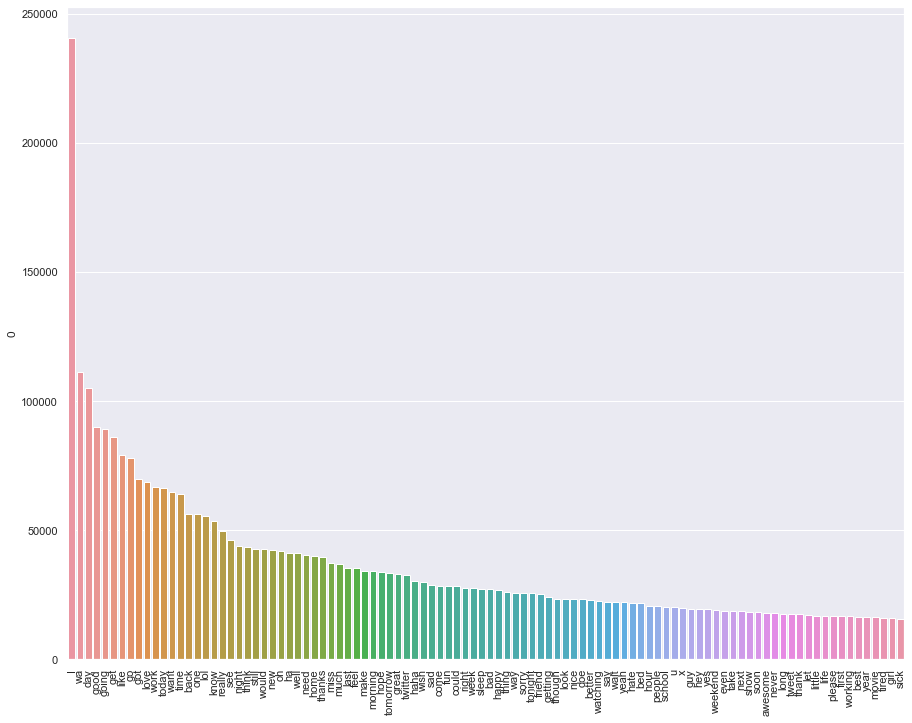

bottom words visualisation:


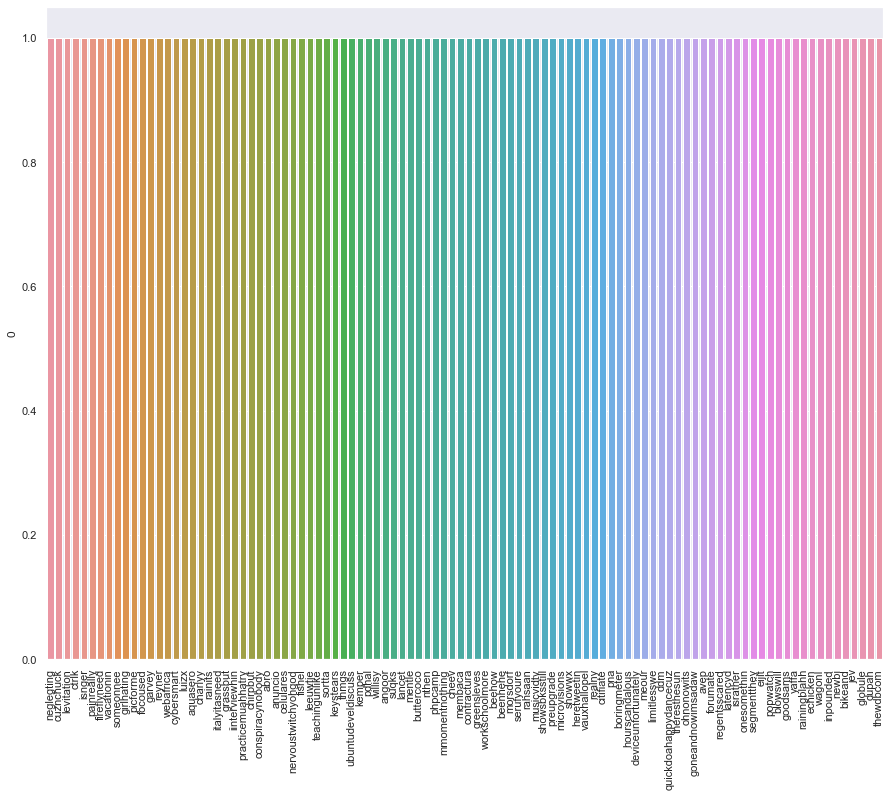

any rows with null values:
word cloud for positive words


,polarity,id,date,query,user,content
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,"[love, guy, r, best]"
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,"[I, meeting, one, besties, tonight, wait, girl..."
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"[thanks, twitter, add, sunisa, got, meet, hin,..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,"[sick, really, cheap, hurt, much, eat, real, f..."
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,"[ha, effect, everyone]"


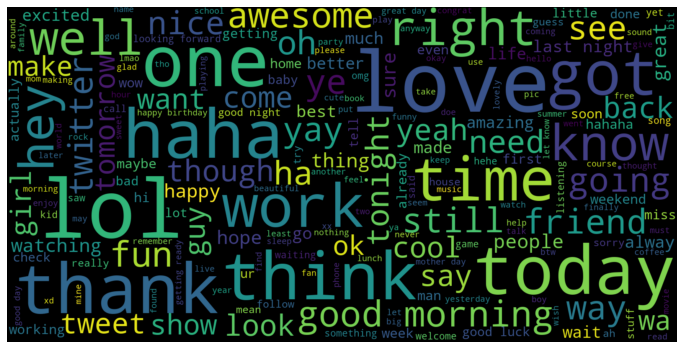

word cloud for negative words


,polarity,id,date,query,user,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[aw, bummer, shoulda, got, david, carr, third,..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[dived, many, time, ball, managed, save, rest,..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[behaving, I, mad, see]"


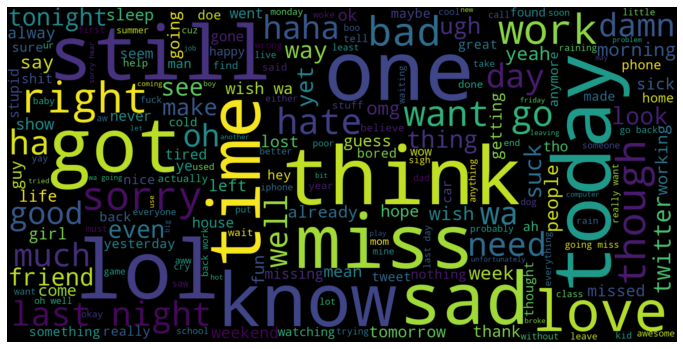

In [58]:
print("describe clean taining data:")
describe_data_set(training_data, True)

# Word Vectorisation

N-Gram Vectorisation

In [5]:


def create_one_grams(data) :    
    return data

def __bigrams(tweets):
    bigrams = [' '.join(t) for t in list(zip(tweets, tweets[1:]))]
    return bigrams

def create_bigram(data) :
    return data.apply(lambda x: __bigrams(x))

def create_sparse_matrix_gram(data, n_gram_size) :
    cv2 = CountVectorizer(ngram_range=(1, n_gram_size))

    vectorized_data = cv2.fit_transform(data)
    return vectorized_data

def pickle_data(data) :
    print("pickle it!")
    
    data.to_pickle(FINAL_DATAFRAME_FILE_LOC)

def unpickle_data() :
    print("from pickle!")
    data = pd.read_pickle(FINAL_DATAFRAME_FILE_LOC)
    display(data.head())
    return data

def pickle_inputs(X, INPUT_FILE) :
    print("pickle it!")
   
    pickle.dump( X, open(INPUT_FILE , "wb" ) )

def unpickle_inputs(INPUT_FILE) :
    print("from pickle!")
    X = pickle.load( open( INPUT_FILE, "rb" ) )
    return X

In [84]:
print('delete any neutral entries from our test data')
test_data = test_data[test_data.polarity != 2]
print('merge our data frames... we will split it later into training and tests but if we dont join them here we end up with differeing feature sets.')
data = training_data.append(test_data, ignore_index=True)

print(data.shape)
print(training_data.shape)
print(test_data.shape)
print(data['polarity'].unique())

delete any neutral entries from our test data
merge our data frames... we will split it later into training and tests but if we dont join them here we end up with differeing feature sets.
(1600359, 9)
(1600000, 9)
(359, 9)
[0 4]


In [87]:
data['onegram'] = create_one_grams(data['content'])
data['bigrams'] = create_one_grams(data['content'])

X_dict = {
    "onegram_vectors": create_sparse_matrix_gram(data['text_content'], 1),
    "bigram_vectors": create_sparse_matrix_gram(data['text_content'], 2)
}

In [88]:
pickle_inputs(X_dict, X_INPUT_FILE_LOC)
pickle_data(data)



pickle it!
pickle it!


In [89]:
X_dict = unpickle_inputs(X_INPUT_FILE_LOC)
data = unpickle_data()

from pickle!
from pickle!


,polarity,id,date,query,user,content,text_content,onegram,bigrams
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[aw, bummer, shoulda, got, david, carr, third, day]",aw bummer shoulda got david carr third day,"[aw, bummer, shoulda, got, david, carr, third, day]","[aw, bummer, shoulda, got, david, carr, third, day]"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry, result, school, today, also, blah]",upset update facebook texting might cry result school today also blah,"[upset, update, facebook, texting, might, cry, result, school, today, also, blah]","[upset, update, facebook, texting, might, cry, result, school, today, also, blah]"
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[dived, many, time, ball, managed, save, rest, go, bound]",dived many time ball managed save rest go bound,"[dived, many, time, ball, managed, save, rest, go, bound]","[dived, many, time, ball, managed, save, rest, go, bound]"
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire,"[whole, body, feel, itchy, like, fire]","[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[behaving, I, mad, see]",behaving I mad see,"[behaving, I, mad, see]","[behaving, I, mad, see]"


In [125]:
#test_data_pos_tagged = pos_tagging(test_data.copy())
#training_data_pos_tagged = pos_tagging(training_data.copy())
#display(test_data_pos_tagged.head())
#display(training_data_pos_tagged.head())

In [126]:
#print("pickle it!")
#test_data_pos_tagged.to_pickle(POS_TAGGED_TEST_FILE_LOC)
#training_data_pos_tagged.to_pickle(POS_TAGGED_TRAIN_FILE_LOC)

In [127]:
#print("from pickle!")
#test_data_pos_tagged = pd.read_pickle(POS_TAGGED_TEST_FILE_LOC)
#training_data_pos_tagged = pd.read_pickle(POS_TAGGED_TRAIN_FILE_LOC)
#display(test_data_pos_tagged.head())
#display(training_data_pos_tagged.head())

In [128]:
#test_data_bigram = make_bigram(test_data.copy())
#training_data_bigram = make_bigram(training_data.copy())
#display(test_data_bigram.head())
#display(training_data_bigram.head())

In [129]:
#print("pickle it!")
#test_data_bigram.to_pickle(BIGRAM_TEST_FILE_LOC)
#training_data_bigram.to_pickle(BIGRAM_TRAIN_FILE_LOC)

In [130]:
#print("from pickle!")
#test_data_bigram = pd.read_pickle(BIGRAM_TEST_FILE_LOC)
#training_data_bigram = pd.read_pickle(BIGRAM_TRAIN_FILE_LOC)
#display(test_data_bigram.head())
#display(training_data_bigram.head())

gloVes

In [227]:
#import zipfile

#wget http://nlp.stanford.edu/data/glove.840B.300d.zip
#zip = zipfile.ZipFile('data/glove.840B.300d.zip')
#zip.extractall()
#GLOVE_840B_300D_PATH = "data/glove.840B.300d.txt"


In [228]:
#glove = {}
#with open(GLOVE_840B_300D_PATH, "rb") as infile:
#    for line in infile:
#        parts = line.split()
#        word = parts[0].decode(encoding)
#        if word in all_words:
#            nums=np.array(parts[1:], dtype=np.float32)
#            glove_big[word] = nums

In [90]:
# creating a corpus object
corpus_model = Corpus() 

#training the corpus to generate the co occurence matrix which is used in GloVe
corpus_model.fit(data['content'], window=10)

corpus_model.save(CORPUS_MODEL)


In [91]:
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
corpus_model = Corpus.load(CORPUS_MODEL)
glove = Glove(no_components=5, learning_rate=0.05)
 
glove.fit(corpus_model.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus_model.dictionary)
glove.save(GLOVE_MODEL)

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [92]:
corpus_model = Corpus.load(CORPUS_MODEL)
glove = Glove.load(GLOVE_MODEL)
glove.add_dictionary(corpus_model.dictionary)

In [108]:
glove_vec = {}
all_words = set(w for words in data['content'] for w in words)

for word in all_words :
    if word not in glove_vec :
        glove_vec[word] = glove.word_vectors[glove.dictionary[word]]
        

In [116]:
pickle_inputs(glove_vec, GLOVE_VEC_VALUES)
glove_vec = unpickle_inputs(GLOVE_VEC_VALUES)

pickle it!
from pickle!


In [123]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[data['content'][0][0]])
        else:
            self.dim=0
        
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [128]:
tdidf_vectorizer = TfidfEmbeddingVectorizer(glove_vec)
tdidf_vectorizer.fit(data['content'])
glove_input_vectors = tdidf_vectorizer.transform(data['content'])

print(glove_input_vectors[0])

[-4.53492601  3.78181606  2.14348671  3.38605007  2.35795046]


In [129]:
X_dict['glove'] = glove_input_vectors
pickle_inputs(X_dict, X_INPUT_FILE_LOC)

pickle it!


In [130]:
X_dict = unpickle_inputs(X_INPUT_FILE_LOC)

from pickle!


In [154]:
%%bash
wget http://nlp.stanford.edu/data/glove.840B.300d.zip --directory-prefix=./data

Process is interrupted.


In [156]:
zip = zipfile.ZipFile('data/glove.840B.300d.zip')
zip.extractall(path='./data')

In [160]:
pretrained_glove_vec = {}
all_words = set(w for words in data['content'] for w in words)
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in all_words:
            if word not in pretrained_glove_vec :
                nums=np.array(parts[1:], dtype=np.float32)
                pretrained_glove_vec[word] = nums

In [161]:
tdidf_vectorizer = TfidfEmbeddingVectorizer(pretrained_glove_vec)
tdidf_vectorizer.fit(data['content'])
pretrained_glove_input_vectors = tdidf_vectorizer.transform(data['content'])

print(pretrained_glove_input_vectors[0])

[-9.30306196e-01  1.40240216e+00 -1.57246351e-01 -1.37864304e+00
 -4.24830079e-01 -4.24961150e-01  5.24019599e-01 -2.30187249e+00
 -1.01471901e+00  6.59346819e+00 -8.15635562e-01 -4.90001231e-01
  1.36685824e+00 -7.99113452e-01 -7.28157818e-01  3.24472964e-01
  1.72947809e-01  1.24619436e+00  7.88865611e-02 -4.85804200e-01
  1.00018549e+00  1.78041145e-01 -1.65717453e-02  7.10566118e-02
  6.69709742e-02 -1.86512148e+00 -1.72056592e+00 -7.34705508e-01
  5.52554786e-01  1.25734293e+00 -1.53002596e+00 -2.20257461e-01
  1.60552132e+00  1.80251288e+00 -1.38761735e+00  2.64114380e-01
  7.87128091e-01  2.27835387e-01 -1.43838263e+00  1.82098001e-01
  1.94446206e-01 -4.70057845e-01 -2.00772390e-01  1.49311900e+00
  7.61961460e-01  1.33823842e-01 -7.30359733e-01 -1.23260343e+00
  1.88788724e+00  1.55380881e+00  1.10505545e+00  4.29653674e-01
  1.52804077e+00  5.78258812e-01  1.03942893e-01  5.64051211e-01
  4.65421617e-01  7.79129148e-01  6.17033660e-01 -1.12600732e+00
 -1.71877909e+00  3.96615

In [162]:
X_dict['pretrained_glove'] = pretrained_glove_input_vectors
pickle_inputs(X_dict, X_INPUT_FILE_LOC)

pickle it!


In [163]:
X_dict = unpickle_inputs(X_INPUT_FILE_LOC)

from pickle!


# Supervised Learning Methods

In [165]:
X = {}
scaler = StandardScaler(with_mean=False)
for key, X_value in X_dict.items():
    X[key] = train_test_split(X_dict[key], data['polarity'], test_size=0.1, random_state=SEED)

In [166]:
pickle_inputs(X, ZIPPED_X_INPUT_FILE_LOC)


pickle it!


In [167]:
X = unpickle_inputs(ZIPPED_X_INPUT_FILE_LOC)

from pickle!


In [150]:

def train_predict(learner, sample_size, X_train, Y_train, X_test, Y_test):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    clf_name = clf.__class__.__name__
    
    if clf_name == 'MultinomialNB' :
        X_train = X_train.clip(min=0)
        X_test = X_test.clip(min=0)

    
    results = {}
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], Y_train[:sample_size])
    end = time() # Get end time

    # TODO: Calculate the training time
    results['train_time'] = end - start

    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time

    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start

    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(Y_train[:300], predictions_train)

    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(Y_test, predictions_test)

    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(Y_train[:300], predictions_train, beta=0.5, pos_label=4)

    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(Y_test, predictions_test, average='binary', beta=0.5, pos_label=4)

    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))

    # Return the results
    return results


In [ ]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

clfs = [
    SVC(random_state=SEED, kernel='linear'),
    LogisticRegression(random_state=SEED),
    MultinomialNB()
]


sample_sizes = [
    int(len(data['polarity'])/100),
    #int((len(data['polarity']) * 10)/100),
    #int((len(data['polarity']) * 50)/100),
    #len(data['polarity'])
]

# Collect results on the learners
results = {}
for clf in clfs:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate(sample_sizes):
        results[clf_name][i] = \
        train_predict(clf, samples, X['pretrained_glove'][0],  X['pretrained_glove'][2],  X['pretrained_glove'][1],  X['pretrained_glove'][3])

display(results)